In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import os
from datetime import datetime as dt

In [2]:
#DEFINE FUNÇÕES PRINCIPAIS PARA ACESSO DO BANCO DE DADOS COM A BASE INICIAL

conn = sqlite3.connect('DIST_DB_ANEEL.db')
cursor = conn.cursor()
conn_bi = sqlite3.connect('BD_POWER_BI_FINAL.db')
cursor_bi = conn_bi.cursor()

In [3]:
#TABELA DE POPULAÇAO POR ESTADO ENTRE OS ANOS 2010 E 2022
#Baseado no censo do IBGE, para fins de simplificação, será considerado que a população cresceu linearmente entre esses anos

def _split_state(df): #Recebe o dataframe com Estado no formato ACRE_AC e separa em duas colunas ACRE e AC

    df_final = df.copy()

    for row in df.itertuples():
        old_column = row.Estado
        old_column = old_column.split('_')
        df_final.at[row.Index,'Estado_nome']=old_column[0]
        df_final.at[row.Index,'Estado_SIGLA']=old_column[1]
    
    df_final.drop(columns=['Estado'], inplace=True)
    df_final.rename(columns={'Estado_nome':'Estado','Estado_SIGLA':'SIGLA'}, inplace=True)
    df_final = df_final[['Ano','Estado','SIGLA','Populacao']]

    return df_final

#Consome planilha com dados do IBGE e estrutura dataframe
df_base = pd.read_excel(r'.\IBGE_POPULACAO_UF.xlsx')

anos = [i for i in range(2010,2023,1)]
estados = list(df_base.columns)
estados = estados[1:]

df_base = df_base.set_index('ANO')
df_base.index.name = None
tabela_censo = pd.DataFrame(columns=estados,index=anos)

#Interpolação linear para obter um numero de população por ano ao inves do range de 10 anos no censo
for estado in estados:
    populacao_2010 = int(df_base.at[2010,estado])
    populacao_2022 = int(df_base.at[2022,estado])
    
    coeficiente_linear = (populacao_2022-populacao_2010)/(2022-2010)
    populacao_x = populacao_2010
    
    for ano in anos: #Corrige possíveis números de população fracionados. 
        
        tabela_censo.at[ano,estado] = round(populacao_x)
        populacao_x = populacao_x + coeficiente_linear

#Reestrutura dados para deixar em formato de subir para o banco de dados
tabela_censo.reset_index(inplace=True)
tabela_censo.rename(columns={'index':'ANO'},inplace=True)
tabela_censo = tabela_censo.transpose()

de_para = tabela_censo.iloc[0]
tabela_censo = tabela_censo.iloc[1:]

tabela_censo_final = pd.DataFrame(columns=['Ano','Estado','Populacao'])
for index, ano in de_para.items():#Loop Ano
    for row2 in tabela_censo.itertuples():#Loop Estado
        _Ano = ano
        Index_column = index + 1
        Estado = row2.Index
        Populacao = row2[Index_column]
 
        dataset = {'Ano':_Ano,'Estado':Estado,'Populacao':Populacao}
        tabela_transitoria = pd.DataFrame(data=[dataset])
        tabela_censo_final = pd.concat([tabela_censo_final,tabela_transitoria],ignore_index=True)

tabela_censo_final = _split_state(tabela_censo_final)

#Sobe tabela para o banco de dados
tabela_censo_final.to_sql('POPULACAO_CENSO_IBGE',conn, if_exists='replace', index=False)



351

**VISAO INADIPLÊNCIA POR REGIAO AO LONGO DOS ANOS**

In [4]:
#Gráfico por UF de financeiro inadiplente por estado
tb_inad = "DIST_INADIPLENCIA"
tb_sigAg = "SIGAGENTE_UF"

query = f""" SELECT {tb_inad}.AnoIndice, {tb_inad}.VlrIndiceEnviado, {tb_sigAg}.RegUF 
                    FROM {tb_inad}
                    INNER JOIN {tb_sigAg} ON {tb_inad}.SigAgente = {tb_sigAg}.SigAgente"""
# cursor.execute()

result = pd.read_sql_query(query,conn)
# result['VlrIndiceEnviado'] = result['VlrIndiceEnviado'].apply(lambda x: str(x).replace(",",".", regex=False))
result['VlrIndiceEnviado'] = result['VlrIndiceEnviado'].str.replace(',','.').astype(float)
result = result.groupby(by=["AnoIndice","RegUF"], as_index=False)["VlrIndiceEnviado"].sum()

result.sort_values(['AnoIndice','RegUF'], ascending=[True,True], inplace=True)


DatabaseError: Execution failed on sql ' SELECT DIST_INADIPLENCIA.AnoIndice, DIST_INADIPLENCIA.VlrIndiceEnviado, SIGAGENTE_UF.RegUF 
                    FROM DIST_INADIPLENCIA
                    INNER JOIN SIGAGENTE_UF ON DIST_INADIPLENCIA.SigAgente = SIGAGENTE_UF.SigAgente': no such table: DIST_INADIPLENCIA

C:\Users\marco\AppData\Local\Temp\ipykernel_16520\4238426651.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  financeiro = float(df['VlrIndiceEnviado'])


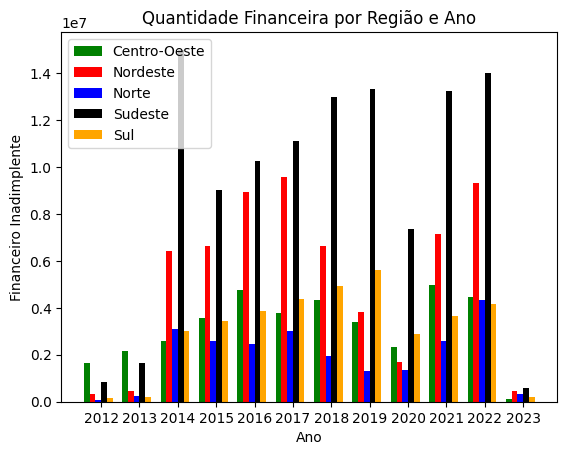

In [5]:
# x = np.array([result['AnoIndice'], result['RegUF']])
regioes = np.unique(result['RegUF'])
anos = np.unique(result['AnoIndice'])
cores = ['green', 'red', 'blue', 'black', 'orange']
financeiro = result['VlrIndiceEnviado']

largura_bar = 0.15
posicoes = np.arange(len(anos))
fig, ax = plt.subplots()


for j, ano in enumerate(anos):
    for i, regiao in enumerate(regioes):

        df = result.loc[(result['AnoIndice']==ano) & (result['RegUF']==regiao)]
        financeiro = float(df['VlrIndiceEnviado'])
        ax.bar(posicoes[j] + i*largura_bar, financeiro, largura_bar, label = str(regiao), color=cores[i])

ax.set_xlabel('Ano')
ax.set_ylabel('Financeiro Inadimplente')
ax.set_title('Quantidade Financeira por Região e Ano')
ax.set_xticks(posicoes + largura_bar * len(regioes) / 2)
ax.set_xticklabels(anos)
ax.legend(regioes)

plt.show()


### **1.0) VISAO PREÇO DE TARIFAS POR ANO AO LONGO DOS ANOS -  ENEL CE**

* Análise feita por grupo de clientes (A e B)
* Contratos com a ANEEL foram serializados em quantidades de dias vigentes em um determinado ano
* Tarifa de aplicação levada em consideração e a tarifa base descartada
* Fator de ponderamento do consumo Ponta e Fora Ponta (X e Y) levou em consideração curva média das cargas no ceará





In [37]:
#Carrega tabela de inflação por ano

query = """

    SELECT *
    FROM INFLACAO_ACUMULADA_POR_ANO

"""

tabelaInflacaoPorAno = pd.read_sql(query,conn)
tabelaInflacaoPorAno['acumuladoAnoAnterior'] = pd.to_datetime(tabelaInflacaoPorAno['acumuladoAnoAnterior'])
print(tabelaInflacaoPorAno)

#Funçao para acumular as as taxas

def aplicaValorAcumuladoIndice(df):

    dfCopy = df.copy()

    for linha in dfCopy.itertuples():
        if linha.Index == 0:
            df.at[linha.Index,'acumuladoIPCA'] = float(1)
            df.at[linha.Index,'acumuladoIGPM'] = float(1)
            df.at[linha.Index,'acumuladoAumentoPercentualCustoGlobal'] = float(1)

            continue

        elif linha.Index == 1:
            ipca = linha.IPCA/100
            ipca = ipca + 1

            igpm = linha.IGPM/100
            igpm = igpm + 1

            aumentoGlobal = linha.AumentoPercentualCustoGlobal/100
            aumentoGlobal = aumentoGlobal + 1

            df.at[linha.Index,'acumuladoIPCA'] = ipca
            df.at[linha.Index,'acumuladoIGPM'] = igpm
            df.at[linha.Index,'acumuladoAumentoPercentualCustoGlobal'] = aumentoGlobal
            
        elif linha.Index > 1:

            indexAnterior = linha.Index
     
            ipcaAnterior = df.at[(linha.Index-1),'acumuladoIPCA']
            igpmAnterior = df.at[(linha.Index-1),'acumuladoIGPM']
            aumentoGlobalAnterior = df.at[(linha.Index-1),'acumuladoAumentoPercentualCustoGlobal']
            
            ipca = ((linha.IPCA)/100)
            ipca = (ipca + 1)*ipcaAnterior

            igpm = linha.IGPM/100
            igpm = (igpm + 1)*igpmAnterior

            aumentoGlobal = linha.AumentoPercentualCustoGlobal/100
            aumentoGlobal = (aumentoGlobal + 1)*aumentoGlobalAnterior

            df.at[linha.Index,'acumuladoIPCA'] = ipca
            df.at[linha.Index,'acumuladoIGPM'] = igpm
            df.at[linha.Index,'acumuladoAumentoPercentualCustoGlobal'] = aumentoGlobal

    return df

   acumuladoAnoAnterior   IPCA   IGPM
0            2011-01-01   5.91  11.32
1            2012-01-01   6.50   5.10
2            2013-01-01   5.84   7.81
3            2014-01-01   5.91   5.53
4            2015-01-01   6.41   3.67
5            2016-01-01  10.67  10.54
6            2017-01-01   6.29   7.19
7            2018-01-01   2.95  -0.53
8            2019-01-01   3.75   7.55
9            2020-01-01   4.31   7.32
10           2021-01-01   4.52  23.14
11           2022-01-01  10.06  17.79
12           2023-01-01   5.79   5.46


In [5]:
#Gráfico por UF de financeiro inadiplente por estado

def _break_year_tax(df): 

    """Funcao que recebe datas de inicio e termino de vigencia da tarifa, calcula quantos dias
        passou em cada ano e gera um novo dataframe serializado com dias por ano de cada preço de tarifa"""
    
    def right_storage(ano,qty_dias,row):
        dataset = {'Ano': ano,
                   'Qty_dias': qty_dias,
                   'DscBaseTarifaria':row.DscBaseTarifaria,
                   'DscSubGrupo': row.DscSubGrupo,
                   'NomPostoTarifario': row.NomPostoTarifario,
                   'DscUnidadeTerciaria': row.DscUnidadeTerciaria,
                   'DscModalidadeTarifaria': row.DscModalidadeTarifaria,
                    'VlrTUSD': row.VlrTUSD,
                    'VlrTE': row.VlrTE,
                    'SigAgente': row.SigAgente,
                    'SigUF': row.SigUF,
                    'RegUF': row.RegUF}
    
        return pd.DataFrame(data=[dataset]) #Retorna dataframe de uma linha no formato final
    

    df['DatInicioVigencia'] = pd.to_datetime(df['DatInicioVigencia'])
    df['DatFimVigencia'] = pd.to_datetime(df['DatFimVigencia'])

    df_consolidado = pd.DataFrame(columns=['Ano','Qty_dias','DscBaseTarifaria','DscSubGrupo','NomPostoTarifario','DscUnidadeTerciaria',\
                                           	'DscModalidadeTarifaria','VlrTUSD','VlrTE','SigAgente','SigUF','RegUF'])
    
    for row in df.itertuples():
        _data_inicio = row.DatInicioVigencia
        _data_temino = row.DatFimVigencia
        _delta_dias = (_data_temino - _data_inicio).days

        _ano_inicio = (row.DatInicioVigencia).year
        _mes_inicio = (row.DatInicioVigencia).month
        _dia_inicio = (row.DatInicioVigencia).day

        _ano_termino = (row.DatFimVigencia).year
        _mes_termino = (row.DatFimVigencia).month
        _dia_termino = (row.DatFimVigencia).day

        #cria data de referência para anos fechados após a data inicio e anterior a data de termino
        _ref_ano_inicio = dt.strptime(f'01/01/{_ano_inicio+1}', "%d/%m/%Y")
        _ref_ano_termino = dt.strptime(f'31/12/{_ano_termino-1}', "%d/%m/%Y")

        if _ano_inicio == _ano_termino:
            df_consolidado = pd.concat([df_consolidado,right_storage(_ano_inicio,_delta_dias,row)], ignore_index=True)
            
        else:
            all_years_range = [x for x in range(_ano_inicio+1,_ano_termino)]

            #Contabiliza os dias para fechar o ano na ponta inicial e final do range
            dif_fisrt_year = (_ref_ano_inicio-_data_inicio).days
            df_consolidado = pd.concat([df_consolidado,right_storage(_ano_inicio,dif_fisrt_year,row)], ignore_index=True)
            dif_last_year = (_data_temino-_ref_ano_termino).days
            df_consolidado = pd.concat([df_consolidado,right_storage(_ano_termino,dif_last_year,row)], ignore_index=True)

            for ano in all_years_range:
                df_consolidado = pd.concat([df_consolidado,right_storage(ano,365,row)], ignore_index=True)

    return df_consolidado


#Variável para as duas tabelas utilizadas na query
tb1 = "DIST_TARIFAS_DISTRIBUIDORAS"
tb_sigAg = "SIGAGENTE_UF"

#Select com as informações pertinentes para a análise, filtrando pela modalidade tarifaria de Distribuição (propósito do estudo) e filtrando pelos postos tarifarios Ponta e Fora Ponta.
query = f""" SELECT {tb1}.DatInicioVigencia, {tb1}.DatFimVigencia, {tb1}.DscBaseTarifaria, {tb1}.DscModalidadeTarifaria, {tb1}.DscSubGrupo, {tb1}.NomPostoTarifario, {tb1}.DscUnidadeTerciaria,\
             {tb1}.VlrTUSD, {tb1}.VlrTE, {tb_sigAg}.SigAgente, {tb_sigAg}.SigUF, {tb_sigAg}.RegUF 

             FROM {tb1}
             INNER JOIN {tb_sigAg} ON {tb1}.SigAgente = {tb_sigAg}.SigAgente 
             WHERE  {tb1}.DscBaseTarifaria = 'Tarifa de Aplicação'\
                    AND {tb1}.SigAgente = 'ENEL CE'\
                    AND {tb1}.DscSubClasse <> 'Baixa Renda'\
                    AND {tb1}.DscSubClasse <> 'Serviço público de irrigação rural'\
                    AND {tb1}.DscSubClasse <> 'Cooperativa de eletrificação rural'\
                    AND {tb1}.DscModalidadeTarifaria <> 'Geração'\
                    AND {tb1}.NomPostoTarifario <> 'Fora ponta seca'\
                    AND {tb1}.NomPostoTarifario <> 'Fora ponta úmida'\
                    AND {tb1}.NomPostoTarifario <> 'Ponta seca'\
                    AND {tb1}.NomPostoTarifario <> 'Ponta úmida'\
                    AND {tb1}.DscModalidadeTarifaria <> 'Azul ABRACE CATIVO'\
                    AND {tb1}.DscModalidadeTarifaria <> 'Verde ABRACE CATIVO'\
                    AND {tb1}.DscModalidadeTarifaria <> 'Azul ABRACE LIVRE'\
                    AND {tb1}.DscModalidadeTarifaria <> 'Convencional ABRACE'\
                    AND {tb1}.DscModalidadeTarifaria <> 'Verde ABRACE LIVRE'\
                    
                    """

#({tb1}.DscModalidadeTarifaria = 'Distribuição' OR {tb1}.DscModalidadeTarifaria = 'Convencional')
result = pd.read_sql_query(query,conn)
# result.to_excel(r".\APAGAR_tarifas.xlsx", index=False)
result = _break_year_tax(result)





In [6]:

result = result.copy()

#Remove linhas duplicadas e tira as tarifas de distribuição zeradas para não atrapalhar nos calculos estatísticos.
result = result.drop(result[result['VlrTUSD'] == ',00'].index)
result = result.drop_duplicates()

#Para valores dados por MWh, transforma a base para KWh
result['VlrTUSD'] = result['VlrTUSD'].str.replace(',','.').astype(float)
for row in result.itertuples():
    if row.DscUnidadeTerciaria == 'MWh':
        result.at[row.Index,'DscUnidadeTerciaria'] = 'KWh'
        result.at[row.Index,'VlrTUSD'] = (row.VlrTUSD/1000)

# result.to_excel(r"C:\Users\marco\Desktop\TCC\SEGREG_TARIFAS.xlsx", index = False)

#Consome condições de contorno para analise das tarifas
_inicial_condition = pd.read_excel(r"C:\Users\marco\Desktop\TCC\CONDICOES_CONTORNO_TARIFAS.xlsx")
result.to_excel(r"C:\Users\marco\Desktop\visao_trifas.xlsx",index=False)



##### **1.1) Análise para consumidores de Baixa Tensão (GRUPO B)**

In [43]:
_df_baixa_tensao = result.loc[(result['DscSubGrupo']=='B1') | (result['DscSubGrupo']=='B2') | (result['DscSubGrupo']=='B3')].copy() #Filtra grupos de baixa tensão
_df_baixa_tensao = _df_baixa_tensao.loc[_df_baixa_tensao['NomPostoTarifario'] == 'Não se aplica'] #Tira da analise a diferenciação de consumo ponta e fora ponta
_df_baixa_tensao = _df_baixa_tensao.loc[_df_baixa_tensao['DscModalidadeTarifaria'] == 'Convencional'] #Tira da analise os beneficios sociais nas tarifas

_df_bt_layout = pd.DataFrame(columns =_df_baixa_tensao.columns)
_df_bt_consolidado = pd.DataFrame(columns =_df_baixa_tensao.columns)

#Pega dias de cada ano
_df_dias_ano = _df_baixa_tensao[['Ano','Qty_dias']].copy()
_df_dias_ano.drop_duplicates(inplace=True)
_df_dias_ano = _df_dias_ano.groupby(by='Ano')['Qty_dias'].sum()
_df_dias_ano = _df_dias_ano.reset_index()

#Multiplica Qty_dias por preço da energia, gerando o numerador da media ponderada
_df_baixa_tensao['VlrTUSD'] = _df_baixa_tensao['VlrTUSD'] * _df_baixa_tensao['Qty_dias']
_df_baixa_tensao = _df_baixa_tensao.groupby(by=['Ano','DscBaseTarifaria','DscSubGrupo','DscModalidadeTarifaria'])['VlrTUSD'].sum()
_df_baixa_tensao = _df_baixa_tensao.reset_index()
# print(_df_baixa_tensao)

#Divide todos os valores pelo numero de dias do ano em questao, representando o denominador da media ponderada
_df_baixa_tensao = _df_baixa_tensao.merge(_df_dias_ano, how='left', on='Ano')
_df_baixa_tensao['VlrTUSD'] = _df_baixa_tensao['VlrTUSD'] / _df_baixa_tensao['Qty_dias']

#Mantem colunas importantes
_df_baixa_tensao = _df_baixa_tensao[['Ano','DscSubGrupo','VlrTUSD']]

#Cruza condiçoes iniciais x resultado da media ponderada das tarifas
_df_baixa_tensao = _df_baixa_tensao.merge(_inicial_condition,how='left',on='DscSubGrupo')
_df_baixa_tensao['CustoGlobalAnual'] = (_df_baixa_tensao['VlrTUSD'] * _df_baixa_tensao['Consumo_kWh']).apply(lambda x: round(x,2))
_df_baixa_tensao['Ano'] = pd.to_datetime(_df_baixa_tensao['Ano'], format='%Y')

#Cria segunda tabela que aglutina todos os subgrupos do grupo de consumidor B + traz os indices de correçao financeira
TarifaBaixaTensaoAnaliseEconomica = _df_baixa_tensao.copy()
TarifaBaixaTensaoAnaliseEconomica = pd.DataFrame(TarifaBaixaTensaoAnaliseEconomica.groupby(['Ano'])['CustoGlobalAnual'].sum())
TarifaBaixaTensaoAnaliseEconomica.reset_index(inplace=True)
TarifaBaixaTensaoAnaliseEconomica['AumentoPercentualCustoGlobal'] = TarifaBaixaTensaoAnaliseEconomica['CustoGlobalAnual'].pct_change()*100
TarifaBaixaTensaoAnaliseEconomica = TarifaBaixaTensaoAnaliseEconomica.merge(tabelaInflacaoPorAno, how='left',left_on='Ano',right_on='acumuladoAnoAnterior')
TarifaBaixaTensaoAnaliseEconomica = TarifaBaixaTensaoAnaliseEconomica.drop(columns=['acumuladoAnoAnterior'])
TarifaBaixaTensaoAnaliseEconomica.fillna(0,inplace=True)
TarifaBaixaTensaoAnaliseEconomica['mediaIndicesFinanceiros'] = (TarifaBaixaTensaoAnaliseEconomica['IPCA'] + TarifaBaixaTensaoAnaliseEconomica['IGPM'])/2

TarifaBaixaTensaoAnaliseEconomica['acumuladoIPCA'] = ""
TarifaBaixaTensaoAnaliseEconomica['acumuladoIGPM'] = ""
TarifaBaixaTensaoAnaliseEconomica['acumuladoMediaIndices'] = ""
TarifaBaixaTensaoAnaliseEconomica['acumuladoAumentoPercentualCustoGlobal'] = ""

TarifaBaixaTensaoAnaliseEconomica = aplicaValorAcumuladoIndice(TarifaBaixaTensaoAnaliseEconomica)
TarifaBaixaTensaoAnaliseEconomica['acumuladoMediaIndices'] = (TarifaBaixaTensaoAnaliseEconomica['acumuladoIPCA'] + TarifaBaixaTensaoAnaliseEconomica['acumuladoIGPM'])/2

TarifaBaixaTensaoAnaliseEconomica['acumuladoIPCA'] = TarifaBaixaTensaoAnaliseEconomica['acumuladoIPCA']-1
TarifaBaixaTensaoAnaliseEconomica['acumuladoIGPM'] = TarifaBaixaTensaoAnaliseEconomica['acumuladoIGPM']-1
TarifaBaixaTensaoAnaliseEconomica['acumuladoMediaIndices'] = TarifaBaixaTensaoAnaliseEconomica['acumuladoMediaIndices']-1
TarifaBaixaTensaoAnaliseEconomica['acumuladoAumentoPercentualCustoGlobal'] = TarifaBaixaTensaoAnaliseEconomica['acumuladoAumentoPercentualCustoGlobal']-1


#Sobe tabela final pro BD do power BI
_df_baixa_tensao.to_sql('TarifaBaixaTensao',conn_bi, if_exists='replace', index=False)
TarifaBaixaTensaoAnaliseEconomica.to_sql('TarifaBaixaTensaoAnaliseEconomica',conn_bi, if_exists='replace', index=False)

print('Atualizada base TarifaBaixaTensao no BD.')



Atualizada base TarifaBaixaTensao no BD.


##### **1.2) Análise para consumidores de Alta Tensão (GRUPO A)**

In [15]:
_df_alta_tensao = result.loc[(result['DscSubGrupo']=='A1') | (result['DscSubGrupo']=='A3') | (result['DscSubGrupo']=='A4')].copy() #Filtra grupos de baixa tensão
# print(_df_alta_tensao)

_df_at_layout = pd.DataFrame(columns =_df_alta_tensao.columns)
_df_at_consolidado = pd.DataFrame(columns =_df_alta_tensao.columns)

#Pega dias de cada ano
_df_dias_ano = _df_alta_tensao[['Ano','Qty_dias']].copy()
_df_dias_ano.drop_duplicates(inplace=True)
_df_dias_ano = _df_dias_ano.groupby(by='Ano')['Qty_dias'].sum()
_df_dias_ano = _df_dias_ano.reset_index()


#Multiplica Qty_dias por preço da energia, gerando o numerador da media ponderada
_df_alta_tensao['VlrTUSD'] = _df_alta_tensao['VlrTUSD'] * _df_alta_tensao['Qty_dias']
_df_alta_tensao = _df_alta_tensao.groupby(by=['Ano','DscBaseTarifaria','DscSubGrupo', 'NomPostoTarifario', 'DscUnidadeTerciaria', 'DscModalidadeTarifaria'])['VlrTUSD'].sum()
_df_alta_tensao = _df_alta_tensao.reset_index()


#Divide todos os valores pelo numero de dias do ano em questao, representando o denominador da media ponderada
_df_alta_tensao = _df_alta_tensao.merge(_df_dias_ano, how='left', on='Ano')
_df_alta_tensao['VlrTUSD'] = _df_alta_tensao['VlrTUSD'] / _df_alta_tensao['Qty_dias']
_df_alta_tensao.to_excel(r"C:\Users\marco\Desktop\teste_parcial.xlsx",index=False)



##### **1.2.1) Análise para consumidores de Alta Tensão (GRUPO A1)**

fator ponta = 60%
fator fora ponta = 40%

In [16]:
_df_alta_tensao_a1 = _df_alta_tensao.loc[_df_alta_tensao['DscSubGrupo'] == 'A1'].copy()
_df_alta_tensao_a1 = _df_alta_tensao_a1[['Ano','DscSubGrupo','NomPostoTarifario','DscUnidadeTerciaria','DscModalidadeTarifaria','VlrTUSD']]


#Guarda dataframe para anos de 2010 e 2011 por serem de caracteristicas distintas
_df_linhas_especiais = _df_alta_tensao_a1.loc[(_df_alta_tensao_a1['Ano'] == 2010) | (_df_alta_tensao_a1['Ano'] == 2011)].copy()


#Aplica os fatores de ponta e fora ponta nas tarifas 
_df_fora_ponta = _df_alta_tensao_a1[_df_alta_tensao_a1['NomPostoTarifario']=='Fora ponta'].copy()
_df_fora_ponta['VlrTUSD'] = _df_fora_ponta['VlrTUSD'].apply(lambda x: x*(0.4))
_df_ponta = _df_alta_tensao_a1[_df_alta_tensao_a1['NomPostoTarifario']=='Ponta'].copy()
_df_ponta['VlrTUSD'] = _df_ponta['VlrTUSD'].apply(lambda x: x*(0.6))

_df_alta_tensao_a1 = pd.concat([_df_fora_ponta,_df_ponta],ignore_index=True)
_df_alta_tensao_a1 = _df_alta_tensao_a1.loc[(_df_alta_tensao_a1['Ano'] != 2010) & (_df_alta_tensao_a1['Ano'] != 2011)].copy() #Exclui anos com linhas especiais
_df_alta_tensao_a1 = pd.concat([_df_alta_tensao_a1,_df_linhas_especiais],ignore_index=True) #Adiciona linhas especiais do df antigo

#Soma tarifas de ponta e fora ponta com os fatores aplicados, para consumo de energia e consumo de tensão
_df_lista = []

for ano in set(_df_alta_tensao_a1['Ano']):
    if ((ano == 2010 ) | (ano == 2011)): #Para os anos de linhas especiais, não trata o valor da tarifa, apenas replica a de ponta
        df = _df_alta_tensao_a1.loc[(_df_alta_tensao_a1['Ano']==ano) & (_df_alta_tensao_a1['NomPostoTarifario']=='Ponta')]
        df = df[['Ano','DscSubGrupo', 'DscUnidadeTerciaria','VlrTUSD']]
        _df_lista.append(df)
        continue

    df = _df_alta_tensao_a1.loc[_df_alta_tensao_a1['Ano']==ano]
    df = df.groupby(by=['Ano','DscSubGrupo', 'DscUnidadeTerciaria'])['VlrTUSD'].sum()
    df = df.reset_index()
    _df_lista.append(df)

#Concatena a lista de dfs por ano
_df_alta_tensao_a1 = pd.concat(_df_lista,ignore_index=True)

#Mantem colunas importantes para calculo consumo x ano e adiciona a chave para o merge
_df_alta_tensao_a1 = _df_alta_tensao_a1[['Ano','DscSubGrupo','DscUnidadeTerciaria','VlrTUSD']]

tensao_base = _inicial_condition.iloc[0,1]
consumo_base = _inicial_condition.iloc[0,2]


#Cruza condiçoes iniciais x resultado da media ponderada das tarifas
_df_a1_consumo = _df_alta_tensao_a1[_df_alta_tensao_a1['DscUnidadeTerciaria']=='KWh'].copy()
_df_a1_consumo['CustoGlobalAnual'] = _df_a1_consumo['VlrTUSD'].apply(lambda x: x*consumo_base)
_df_a1_tensao = _df_alta_tensao_a1[_df_alta_tensao_a1['DscUnidadeTerciaria']=='kW'].copy()
_df_a1_tensao['CustoGlobalAnual'] = _df_a1_tensao['VlrTUSD'].apply(lambda x: x*tensao_base)

_df_alta_tensao_a1 = pd.concat([_df_a1_consumo,_df_a1_tensao],ignore_index=True)

_df_alta_tensao_a1['CustoGlobalAnual'] = _df_alta_tensao_a1['CustoGlobalAnual'].apply(lambda x: round(x,2))
_df_alta_tensao_a1['Ano'] = pd.to_datetime(_df_alta_tensao_a1['Ano'], format='%Y')


_df_alta_tensao_a1.to_sql('TarifaAltaTensaoA1',conn_bi, if_exists='replace', index=False)
print(_df_alta_tensao_a1)

#

print('Atualizada base TarifaAltaTensaoA1 no BD.')




    


          Ano DscSubGrupo DscUnidadeTerciaria   VlrTUSD  CustoGlobalAnual
0  2016-01-01          A1                 KWh  0.018613           1861.32
1  2017-01-01          A1                 KWh  0.014192           1419.19
2  2018-01-01          A1                 KWh  0.017238           1723.78
3  2019-01-01          A1                 KWh   0.02224           2223.96
4  2020-01-01          A1                 KWh  0.024715           2471.53
5  2021-01-01          A1                 KWh  0.007895            789.47
6  2010-01-01          A1                 KWh   0.02331           2331.00
7  2011-01-01          A1                 KWh   0.02331           2331.00
8  2012-01-01          A1                 KWh  0.017411           1741.11
9  2013-01-01          A1                 KWh  0.005518            551.81
10 2014-01-01          A1                 KWh  0.004707            470.70
11 2015-01-01          A1                 KWh  0.015391           1539.11
12 2016-01-01          A1             

##### **1.2.2) Análise para consumidores de Alta Tensão (GRUPO A3)**

fator ponta = 60%
fator fora ponta = 40%

In [17]:
_df_alta_tensao_a3 = _df_alta_tensao.loc[(_df_alta_tensao['DscSubGrupo'] == 'A3') & (_df_alta_tensao['DscModalidadeTarifaria'] != 'Convencional') ].copy()
_df_alta_tensao_a3 = _df_alta_tensao_a3[['Ano','DscSubGrupo','NomPostoTarifario','DscUnidadeTerciaria','DscModalidadeTarifaria','VlrTUSD']]

#Aplica os fatores de ponta e fora ponta nas tarifas 
_df_fora_ponta = _df_alta_tensao_a3[_df_alta_tensao_a3['NomPostoTarifario']=='Fora ponta'].copy()
_df_fora_ponta['VlrTUSD'] = _df_fora_ponta['VlrTUSD'].apply(lambda x: x*(0.4))
_df_ponta = _df_alta_tensao_a3[_df_alta_tensao_a3['NomPostoTarifario']=='Ponta'].copy()
_df_ponta['VlrTUSD'] = _df_ponta['VlrTUSD'].apply(lambda x: x*(0.6))

_df_alta_tensao_a3 = pd.concat([_df_fora_ponta,_df_ponta],ignore_index=True)

#Soma tarifas de ponta e fora ponta com os fatores aplicados, para consumo de energia e consumo de tensão
_df_lista = []

for ano in set(_df_alta_tensao_a3['Ano']):
    df = _df_alta_tensao_a3.loc[_df_alta_tensao_a3['Ano']==ano]
    df = df.groupby(by=['Ano','DscSubGrupo', 'DscUnidadeTerciaria'])['VlrTUSD'].sum()
    df = df.reset_index()
    _df_lista.append(df)


#Concatena a lista de dfs por ano
_df_alta_tensao_a3 = pd.concat(_df_lista,ignore_index=True)

#Mantem colunas importantes para calculo consumo x ano e adiciona a chave para o merge
_df_alta_tensao_a3 = _df_alta_tensao_a3[['Ano','DscSubGrupo','DscUnidadeTerciaria','VlrTUSD']]

tensao_base = _inicial_condition.iloc[1,1]
consumo_base = _inicial_condition.iloc[1,2]

#Cruza condiçoes iniciais x resultado da media ponderada das tarifas
_df_a3_consumo = _df_alta_tensao_a3[_df_alta_tensao_a3['DscUnidadeTerciaria']=='KWh'].copy()
_df_a3_consumo['CustoGlobalAnual'] = _df_a3_consumo['VlrTUSD'].apply(lambda x: x*consumo_base)
_df_a3_tensao = _df_alta_tensao_a3[_df_alta_tensao_a3['DscUnidadeTerciaria']=='kW'].copy()
_df_a3_tensao['CustoGlobalAnual'] = _df_a3_tensao['VlrTUSD'].apply(lambda x: x*tensao_base)

_df_alta_tensao_a3 = pd.concat([_df_a3_consumo,_df_a3_tensao],ignore_index=True)

_df_alta_tensao_a3['CustoGlobalAnual'] = _df_alta_tensao_a3['CustoGlobalAnual'].apply(lambda x: round(x,2))
_df_alta_tensao_a3['Ano'] = pd.to_datetime(_df_alta_tensao_a3['Ano'], format='%Y')


_df_alta_tensao_a3.to_sql('TarifaAltaTensaoA3',conn_bi, if_exists='replace', index=False)
print('Atualizada base TarifaAltaTensaoA3 no BD.')



Atualizada base TarifaAltaTensaoA3 no BD.


##### **1.2.3) Análise para consumidores de Alta Tensão (GRUPO A4)**

fator ponta = 60%
fator fora ponta = 40%

In [18]:
_df_alta_tensao_a4 = _df_alta_tensao.loc[(_df_alta_tensao['DscSubGrupo'] == 'A4') & (_df_alta_tensao['DscModalidadeTarifaria'] != 'Convencional') &  (_df_alta_tensao['NomPostoTarifario'] != 'Não se aplica') ].copy()
_df_alta_tensao_a4 = _df_alta_tensao_a4[['Ano','DscSubGrupo','NomPostoTarifario','DscUnidadeTerciaria','DscModalidadeTarifaria','VlrTUSD']]

#Aplica os fatores de ponta e fora ponta nas tarifas 
_df_fora_ponta = _df_alta_tensao_a4[_df_alta_tensao_a4['NomPostoTarifario']=='Fora ponta'].copy()
_df_fora_ponta['VlrTUSD'] = _df_fora_ponta['VlrTUSD'].apply(lambda x: x*(0.4))
_df_ponta = _df_alta_tensao_a4[_df_alta_tensao_a4['NomPostoTarifario']=='Ponta'].copy()
_df_ponta['VlrTUSD'] = _df_ponta['VlrTUSD'].apply(lambda x: x*(0.6))

_df_alta_tensao_a4 = pd.concat([_df_fora_ponta,_df_ponta],ignore_index=True)

#Soma tarifas de ponta e fora ponta com os fatores aplicados, para consumo de energia e consumo de tensão
_df_lista = []

for ano in set(_df_alta_tensao_a4['Ano']):
    df = _df_alta_tensao_a4.loc[_df_alta_tensao_a4['Ano']==ano]
    df = df.groupby(by=['Ano','DscSubGrupo', 'DscUnidadeTerciaria', 'DscModalidadeTarifaria'])['VlrTUSD'].sum()
    df = df.reset_index()
    _df_lista.append(df)

#Concatena a lista de dfs por ano
_df_alta_tensao_a4 = pd.concat(_df_lista,ignore_index=True)

#Mantem colunas importantes para calculo consumo x ano e adiciona a chave para o merge
_df_alta_tensao_a4 = _df_alta_tensao_a4[['Ano','DscSubGrupo','DscUnidadeTerciaria','DscModalidadeTarifaria','VlrTUSD']]


tensao_base = _inicial_condition.iloc[2,1]
consumo_base = _inicial_condition.iloc[2,2]

#Cruza condiçoes iniciais x resultado da media ponderada das tarifas
_df_a4_consumo = _df_alta_tensao_a4[_df_alta_tensao_a4['DscUnidadeTerciaria']=='KWh'].copy()
_df_a4_consumo['CustoGlobalAnual'] = _df_a4_consumo['VlrTUSD'].apply(lambda x: x*consumo_base)
_df_a4_tensao = _df_alta_tensao_a4[_df_alta_tensao_a4['DscUnidadeTerciaria']=='kW'].copy()
_df_a4_tensao['CustoGlobalAnual'] = _df_a4_tensao['VlrTUSD'].apply(lambda x: x*tensao_base)

_df_alta_tensao_a4 = pd.concat([_df_a4_consumo,_df_a4_tensao],ignore_index=True)

_df_alta_tensao_a4['CustoGlobalAnual'] = _df_alta_tensao_a4['CustoGlobalAnual'].apply(lambda x: round(x,2))
_df_alta_tensao_a4['Ano'] = pd.to_datetime(_df_alta_tensao_a4['Ano'], format='%Y')


_df_alta_tensao_a4.to_sql('TarifaAltaTensaoA4',conn_bi, if_exists='replace', index=False)
print('Atualizada base TarifaAltaTensaoA4 no BD.')

Atualizada base TarifaAltaTensaoA4 no BD.


In [42]:
def aplicaValorAcumuladoIndice(df):

    dfCopy = df.copy()

    for linha in dfCopy.itertuples():
        if linha.Index == 0:
            df.at[linha.Index,'acumuladoIPCA'] = float(1)
            df.at[linha.Index,'acumuladoIGPM'] = float(1)
            df.at[linha.Index,'acumuladoAumentoPercentualCustoGlobal'] = float(1)

            continue

        elif linha.Index == 1:
            ipca = linha.IPCA/100
            ipca = ipca + 1

            igpm = linha.IGPM/100
            igpm = igpm + 1

            aumentoGlobal = linha.AumentoPercentualCustoGlobal/100
            aumentoGlobal = aumentoGlobal + 1

            df.at[linha.Index,'acumuladoIPCA'] = ipca
            df.at[linha.Index,'acumuladoIGPM'] = igpm
            df.at[linha.Index,'acumuladoAumentoPercentualCustoGlobal'] = aumentoGlobal
            
        elif linha.Index > 1:

            indexAnterior = linha.Index
     
            ipcaAnterior = df.at[(linha.Index-1),'acumuladoIPCA']
            igpmAnterior = df.at[(linha.Index-1),'acumuladoIGPM']
            aumentoGlobalAnterior = df.at[(linha.Index-1),'acumuladoAumentoPercentualCustoGlobal']
            
            ipca = ((linha.IPCA)/100)
            ipca = (ipca + 1)*ipcaAnterior

            igpm = linha.IGPM/100
            igpm = (igpm + 1)*igpmAnterior

            aumentoGlobal = linha.AumentoPercentualCustoGlobal/100
            aumentoGlobal = (aumentoGlobal + 1)*aumentoGlobalAnterior

            df.at[linha.Index,'acumuladoIPCA'] = ipca
            df.at[linha.Index,'acumuladoIGPM'] = igpm
            df.at[linha.Index,'acumuladoAumentoPercentualCustoGlobal'] = aumentoGlobal

    return df



#Cria segunda tabela que aglutina todos os subgrupos do grupo de consumidor A + traz os indices de correçao financeira

listaTabelasConcatenadas = [_df_alta_tensao_a1,_df_alta_tensao_a3,_df_alta_tensao_a4]

TarifaAltaTensaoAnaliseEconomica = pd.concat(listaTabelasConcatenadas)
TarifaAltaTensaoAnaliseEconomica = pd.DataFrame(TarifaAltaTensaoAnaliseEconomica.groupby(['Ano'])['CustoGlobalAnual'].sum())
TarifaAltaTensaoAnaliseEconomica.reset_index(inplace=True)
TarifaAltaTensaoAnaliseEconomica['AumentoPercentualCustoGlobal'] = TarifaAltaTensaoAnaliseEconomica['CustoGlobalAnual'].pct_change()*100

TarifaAltaTensaoAnaliseEconomica = TarifaAltaTensaoAnaliseEconomica.merge(tabelaInflacaoPorAno, how='left',left_on='Ano',right_on='acumuladoAnoAnterior')
TarifaAltaTensaoAnaliseEconomica = TarifaAltaTensaoAnaliseEconomica.drop(columns=['acumuladoAnoAnterior'])
TarifaAltaTensaoAnaliseEconomica.fillna(0,inplace=True)
TarifaAltaTensaoAnaliseEconomica['mediaIndicesFinanceiros'] = (TarifaAltaTensaoAnaliseEconomica['IPCA'] + TarifaAltaTensaoAnaliseEconomica['IGPM'])/2

TarifaAltaTensaoAnaliseEconomica['acumuladoIPCA'] = ""
TarifaAltaTensaoAnaliseEconomica['acumuladoIGPM'] = ""
TarifaAltaTensaoAnaliseEconomica['acumuladoMediaIndices'] = ""
TarifaAltaTensaoAnaliseEconomica['acumuladoAumentoPercentualCustoGlobal'] = ""

TarifaAltaTensaoAnaliseEconomica = aplicaValorAcumuladoIndice(TarifaAltaTensaoAnaliseEconomica)
TarifaAltaTensaoAnaliseEconomica['acumuladoMediaIndices'] = (TarifaAltaTensaoAnaliseEconomica['acumuladoIPCA'] + TarifaAltaTensaoAnaliseEconomica['acumuladoIGPM'])/2

TarifaAltaTensaoAnaliseEconomica['acumuladoIPCA'] = TarifaAltaTensaoAnaliseEconomica['acumuladoIPCA']-1
TarifaAltaTensaoAnaliseEconomica['acumuladoIGPM'] = TarifaAltaTensaoAnaliseEconomica['acumuladoIGPM']-1
TarifaAltaTensaoAnaliseEconomica['acumuladoMediaIndices'] = TarifaAltaTensaoAnaliseEconomica['acumuladoMediaIndices']-1
TarifaAltaTensaoAnaliseEconomica['acumuladoAumentoPercentualCustoGlobal'] = TarifaAltaTensaoAnaliseEconomica['acumuladoAumentoPercentualCustoGlobal']-1

#Sobe tabela final pro BD do power BI
TarifaAltaTensaoAnaliseEconomica.to_sql('TarifaAltaTensaoAnaliseEconomica',conn_bi, if_exists='replace', index=False)



14